In [1]:
# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score, cohen_kappa_score
)
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
import timm
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Define Model Architecture (Same as training)
# ============================================================
class SSLEfficientNet(nn.Module):
    """EfficientNet backbone - matching original architecture"""
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.3):
        super(SSLEfficientNet, self).__init__()
        
        # Load pretrained backbone
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        
        # Feature projector - MUST match original architecture (no BatchNorm)
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )
        
        # Classification head with controlled dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize additional layers"""
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    
    def forward(self, x, return_features=False):
        """Forward pass with optional feature return"""
        features = self.backbone(x)
        logits = self.classifier(features)
        
        if return_features:
            projected_features = self.projector(features)
            return logits, features, projected_features
        
        return logits
    
    def extract_features(self, x):
        """Extract features without classification"""
        with torch.no_grad():
            features = self.backbone(x)
            return features

def create_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.3):
    """Create and return model"""
    model = SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)
    return model

print("Model architecture defined")

Model architecture defined


In [4]:
# ============================================================
# Define Dataset and Data Loading Classes
# ============================================================
class LabeledDataset(Dataset):
    """Dataset for labeled images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label, img_path
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            blank_img = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                blank_img = self.transform(blank_img)
            return blank_img, label, img_path

def load_datasets():
    """Load and prepare datasets"""
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir = data_dir / "labeled"
    unlabeled_dir = data_dir / "unlabeled"
    
    # Load labeled data
    labeled_paths, labels = [], []
    class_to_idx = {"Negative": 0, "Positive": 1}
    
    for class_name, class_idx in class_to_idx.items():
        class_dir = labeled_dir / class_name
        if class_dir.exists():
            for img_path in class_dir.glob("*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    labeled_paths.append(str(img_path))
                    labels.append(class_idx)
    
    print(f"Loaded {len(labeled_paths)} labeled images")
    print(f"Class distribution: {Counter(labels)}")
    
    # Split labeled data into train/validation
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        labeled_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Training set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    
    # Load unlabeled data
    unlabeled_paths = []
    if unlabeled_dir.exists():
        for img_path in unlabeled_dir.glob("*"):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                unlabeled_paths.append(str(img_path))
    
    print(f"Loaded {len(unlabeled_paths)} unlabeled images")
    
    return (train_paths, train_labels, val_paths, val_labels, unlabeled_paths)

print("Data loading functions defined")

Data loading functions defined


In [5]:
# ============================================================
# Load Configuration and Setup
# ============================================================
ARTIFACTS_DIR = Path("artifacts")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load configurations
with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
    data_metadata = json.load(f)
    
with open(ARTIFACTS_DIR / "model_config.json", "r") as f:
    model_config = json.load(f)

CLASS_NAMES = ["Negative", "Positive"]  # Binary classification
IMG_SIZE = model_config["model_architecture"]["img_size"]

print(f"Evaluation setup:")
print(f"  Device: {DEVICE}")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Model: {model_config['model_architecture']['backbone']}")

Evaluation setup:
  Device: cpu
  Classes: ['Negative', 'Positive']
  Model: efficientnet_b0


In [6]:
# ============================================================
# Evaluation Functions
# ============================================================
def load_model(model_path, dropout_rate=0.3):
    """Load a trained model from a given path."""
    print(f"Loading model: {model_path}")
    
    # Load checkpoint
    # MODIFICATION: Added weights_only=False to allow loading the full checkpoint object
    checkpoint = torch.load(model_path, map_location=DEVICE, weights_only=False)
    
    # Create model
    model = create_model(
        num_classes=model_config["model_architecture"]["num_classes"],
        model_name=model_config["model_architecture"]["backbone"],
        dropout_rate=dropout_rate
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)
    model.eval()
    
    print(f"Model loaded successfully")
    if 'epoch' in checkpoint:
        print(f"  Training epoch: {checkpoint.get('epoch', -1) + 1}")
    if 'val_accuracy' in checkpoint:
        print(f"  Validation accuracy: {checkpoint.get('val_accuracy', 0):.2f}%")
    if 'metrics' in checkpoint:
        print(f"  Sensitivity: {checkpoint['metrics'].get('sensitivity', 0):.3f}")
        print(f"  False Negatives: {checkpoint['metrics'].get('false_negatives', 'N/A')}")
    
    return model, checkpoint

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, confidence_level=0.95):
    """Calculate confidence intervals using bootstrap"""
    scores = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = resample(range(n_samples), n_samples=n_samples, random_state=None)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices] if y_pred.ndim == 1 else y_pred[indices]
        
        try:
            score = metric_func(y_true_boot, y_pred_boot)
            scores.append(score)
        except:
            continue
    
    scores = np.array(scores)
    alpha = 1 - confidence_level
    lower = np.percentile(scores, (alpha/2) * 100)
    upper = np.percentile(scores, (1 - alpha/2) * 100)
    mean_score = np.mean(scores)
    
    return mean_score, lower, upper

def evaluate_model(model, data_loader, threshold=0.5):
    """Evaluate model and return predictions and probabilities using a specific threshold."""
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in data_loader:
            images = images.to(DEVICE)
            
            # Get model outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()
            
            # Use the provided threshold for binary prediction
            predictions = (probabilities[:, 1] >= threshold).astype(int)
            
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_paths.extend(paths)
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities), all_paths

print("Evaluation functions defined")

Evaluation functions defined


In [7]:
# ============================================================
# Clinical Metrics & Additional Evaluation Functions
# ============================================================
def calculate_clinical_metrics(y_true, y_proba, target_specificity=0.7):
    """Calculate clinical deployment metrics"""
    pos_proba = y_proba[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, pos_proba)
    roc_auc = auc(fpr, tpr)
    specificity = 1 - fpr
    valid_indices = specificity >= target_specificity
    
    if np.any(valid_indices):
        best_idx = np.argmax(tpr[valid_indices])
        actual_idx = np.where(valid_indices)[0][best_idx]
        chosen_threshold = thresholds[actual_idx]
        achieved_sensitivity = tpr[actual_idx]
        achieved_specificity = specificity[actual_idx]
        y_pred_binary = (pos_proba >= chosen_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    else:
        chosen_threshold, achieved_sensitivity, achieved_specificity, ppv, npv = [np.nan, 0.0, 0.0, 0.0, 0.0]
    
    return {
        'auc': roc_auc, 'threshold': chosen_threshold,
        'sensitivity': achieved_sensitivity, 'specificity': achieved_specificity,
        'ppv': ppv, 'npv': npv, 'prevalence': np.mean(y_true),
        'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds
    }

def plot_misclassified_images(df, num_images=5):
    """Plots a sample of misclassified images for case-level review."""
    misclassified_df = df[df['correct_prediction'] == False]
    if misclassified_df.empty:
        print("No misclassified images to display.")
        return

    # Separate False Positives and False Negatives
    fp_df = misclassified_df[misclassified_df['true_label'] == 0]
    fn_df = misclassified_df[misclassified_df['true_label'] == 1]

    for title, sample_df in [("False Positives", fp_df), ("False Negatives", fn_df)]:
        if sample_df.empty:
            continue
        
        print(f"\n--- {title} (Sample) ---")
        sample_df = sample_df.head(num_images)
        plt.figure(figsize=(15, 4 * ((len(sample_df) - 1) // 3 + 1)))
        
        for i, row in enumerate(sample_df.itertuples()):
            plt.subplot(1, num_images, i + 1)
            img = Image.open(row.image_path)
            plt.imshow(img)
            plt.title(f"Pred: {CLASS_NAMES[row.predicted_label]}\nProb(Pos): {row.probability_positive:.2f}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def calculate_inter_model_agreement(val_loader):
    """Compares the SSL and High-Sensitivity models using Cohen's Kappa."""
    print("\n--- Inter-Rater (Model vs. Model) Agreement ---")
    
    # Load both models
    ssl_model_path = list(ARTIFACTS_DIR.glob("ssl_model_best_*.pth"))[0] #  
    ssl_model, _ = load_model(ssl_model_path, dropout_rate=0.5)
    hs_model, hs_checkpoint = load_model(ARTIFACTS_DIR / "high_sensitivity_model.pth", dropout_rate=0.3)
    hs_threshold = hs_checkpoint.get('threshold', 0.5)

    # Get predictions from both models
    _, ssl_preds, _, _ = evaluate_model(ssl_model, val_loader, threshold=0.5)
    _, hs_preds, _, _ = evaluate_model(hs_model, val_loader, threshold=hs_threshold)

    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(ssl_preds, hs_preds)
    print(f"\nCohen's Kappa between SSL model and High-Sensitivity model: {kappa:.3f}")
    
    if kappa > 0.8:
        print("Interpretation: Almost perfect agreement. The models behave very similarly.")
    elif kappa > 0.6:
        print("Interpretation: Substantial agreement. The models are quite similar.")
    elif kappa > 0.4:
        print("Interpretation: Moderate agreement. Models differ on a number of cases.")
    else:
        print("Interpretation: Fair to slight agreement. The fine-tuning significantly changed the model's behavior.")

print("Clinical metrics and new evaluation functions defined")

Clinical metrics and new evaluation functions defined


In [8]:
# ============================================================
# Visualization Functions
# ============================================================
def plot_evaluation_results(y_true, y_pred, y_proba, clinical_metrics, save_dir):
    """Create comprehensive evaluation plots"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('High-Sensitivity Model Evaluation', fontsize=16, fontweight='bold')
    
    # 1. ROC Curve
    ax = axes[0, 0]
    ax.plot(clinical_metrics['fpr'], clinical_metrics['tpr'], 
            lw=2, label=f'ROC (AUC = {clinical_metrics["auc"]:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    
    # Mark chosen threshold
    if not np.isnan(clinical_metrics['threshold']):
        threshold_idx = np.argmin(np.abs(clinical_metrics['thresholds'] - clinical_metrics['threshold']))
        ax.scatter(clinical_metrics['fpr'][threshold_idx], clinical_metrics['tpr'][threshold_idx], 
                  color='red', s=100, zorder=5, label=f'Op. threshold ({clinical_metrics["threshold"]:.2f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    ax = axes[0, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
    ap_score = average_precision_score(y_true, y_proba[:, 1])
    
    ax.plot(recall, precision, lw=2, label=f'PR (AP = {ap_score:.3f})')
    ax.axhline(y=clinical_metrics['prevalence'], color='r', linestyle='--', 
              label=f'Baseline (prevalence = {clinical_metrics["prevalence"]:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision (PPV)')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Calibration Plot
    ax = axes[0, 2]
    try:
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_proba[:, 1], n_bins=5, strategy='uniform'
        )
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", 
               label="Model", marker='o', markersize=8)
        ax.plot([0, 1], [0, 1], "k:", alpha=0.5, label="Perfect calibration")
        brier_score = np.mean((y_proba[:, 1] - y_true) ** 2)
        ax.text(0.05, 0.95, f'Brier Score: {brier_score:.3f}', transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    except ValueError as e:
        ax.text(0.5, 0.5, f'Calibration plot unavailable\n({str(e)})', ha='center', va='center', transform=ax.transAxes)
    
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title('Calibration Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Confusion Matrix
    ax = axes[1, 0]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix (Threshold={clinical_metrics["threshold"]:.2f})')
    
    # 5. Threshold Analysis
    ax = axes[1, 1]
    specificity_curve = 1 - clinical_metrics['fpr']
    ax.plot(clinical_metrics['thresholds'], clinical_metrics['tpr'], label='Sensitivity', linewidth=2)
    ax.plot(clinical_metrics['thresholds'], specificity_curve, label='Specificity', linewidth=2)
    if not np.isnan(clinical_metrics['threshold']):
        ax.axvline(clinical_metrics['threshold'], color='red', linestyle='--', label=f'Chosen threshold')
    ax.set_xlabel('Decision Threshold')
    ax.set_ylabel('Metric Value')
    ax.set_title('Sensitivity vs Specificity')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])

    # 6. Probability Distribution
    ax = axes[1, 2]
    pos_proba = y_proba[:, 1]
    neg_proba = pos_proba[y_true == 0]
    pos_proba_true = pos_proba[y_true == 1]
    sns.histplot(neg_proba, bins=20, alpha=0.7, label=f'Negative (n={len(neg_proba)})', color='blue', kde=True, ax=ax)
    sns.histplot(pos_proba_true, bins=20, alpha=0.7, label=f'Positive (n={len(pos_proba_true)})', color='red', kde=True, ax=ax)
    if not np.isnan(clinical_metrics['threshold']):
        ax.axvline(clinical_metrics['threshold'], color='black', linestyle='--', label=f'Decision threshold')
    ax.set_xlabel('Predicted Probability (Positive Class)')
    ax.set_ylabel('Density')
    ax.set_title('Probability Distribution by True Class')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_dir / "evaluation_results.png", dpi=150, bbox_inches='tight')
    plt.show()

print("Visualization functions defined")

Visualization functions defined


In [9]:
# ============================================================
# Report Generation Functions
# ============================================================
def generate_evaluation_report(y_true, y_pred, y_proba, clinical_metrics, paths):
    """Generate comprehensive evaluation report with expanded statistical testing."""
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    # --- Statistical Significance (Bootstrapping) ---
    def sensitivity_func(yt, yp): 
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel(); return tp / (tp + fn) if (tp + fn) > 0 else 0
    def specificity_func(yt, yp):
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel(); return tn / (tn + fp) if (tn + fp) > 0 else 0
    def ppv_func(yt, yp):
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel(); return tp / (tp + fp) if (tp + fp) > 0 else 0
    def npv_func(yt, yp):
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel(); return tn / (tn + fn) if (tn + fn) > 0 else 0

    metrics_ci = {}
    for name, func in [("auc", roc_auc_score), ("sensitivity", sensitivity_func), 
                       ("specificity", specificity_func), ("ppv", ppv_func), ("npv", npv_func)]:
        # For AUC, use probabilities; for others, use binary predictions
        y_for_metric = y_proba[:, 1] if name == 'auc' else y_pred
        mean, lower, upper = bootstrap_metric(y_true, y_for_metric, func)
        metrics_ci[name] = {"mean": float(mean), "ci_lower": float(lower), "ci_upper": float(upper)}

    # Error analysis
    error_mask = (y_true != y_pred)
    error_indices = np.where(error_mask)[0]
    error_analysis = {}
    for true_class in [0, 1]:
        for pred_class in [0, 1]:
            if true_class != pred_class:
                mask = (y_true == true_class) & (y_pred == pred_class)
                count = np.sum(mask)
                if count > 0:
                    avg_confidence = np.mean(np.max(y_proba[mask], axis=1))
                    error_analysis[f"{CLASS_NAMES[true_class]} → {CLASS_NAMES[pred_class]}"] = {
                        'count': int(count), 'avg_confidence': float(avg_confidence)
                    }
    # Compile results
    results = {
        "model_info": {"architecture": model_config["model_architecture"]["backbone"]},
        "dataset_info": {"n_samples": len(y_true), "prevalence": float(np.mean(y_true))},
        "classification_report": report,
        "confusion_matrix": cm.tolist(),
        "metrics_with_ci": metrics_ci,
        "clinical_thresholds": {k: (float(v) if not np.isnan(v) else None) for k, v in clinical_metrics.items() if k not in ['fpr', 'tpr', 'thresholds']},
        "error_analysis": {"total_errors": int(len(error_indices)), "error_rate": float(len(error_indices) / len(y_true)), "error_breakdown": error_analysis}
    }
    return results

def print_clinical_summary(results):
    print("\n" + "="*60)
    print("CLINICAL DEPLOYMENT ASSESSMENT (High-Sensitivity Model)")
    print("="*60)
    metrics = results["clinical_thresholds"]
    auc_info = results["metrics_with_ci"]["auc"]
    sens_info = results["metrics_with_ci"]["sensitivity"]
    spec_info = results["metrics_with_ci"]["specificity"]
    npv_info = results["metrics_with_ci"]["npv"]

    print(f"Model Performance at Optimized Threshold ({metrics['threshold']:.3f}):")
    print(f"  • AUC: {auc_info['mean']:.3f} (95% CI: [{auc_info['ci_lower']:.3f}, {auc_info['ci_upper']:.3f}])")
    print(f"  • Sensitivity: {sens_info['mean']:.3f} (95% CI: [{sens_info['ci_lower']:.3f}, {sens_info['ci_upper']:.3f}])")
    print(f"  • Specificity: {spec_info['mean']:.3f} (95% CI: [{spec_info['ci_lower']:.3f}, {spec_info['ci_upper']:.3f}])")
    print(f"  • NPV: {npv_info['mean']:.3f} (95% CI: [{npv_info['ci_lower']:.3f}, {npv_info['ci_upper']:.3f}])")
    
    print(f"\nClinical Interpretation:")
    if sens_info['mean'] >= 0.95:
        print("  ✓ Excellent sensitivity, suitable for screening to minimize missed cases.")
    else:
        print("  ⚠ Sensitivity is below the 95% target, indicating a risk of false negatives.")

    if npv_info['mean'] >= 0.95:
        print("  ✓ High NPV suggests a 'Negative' result is very likely to be correct.")
    else:
        print("  ⚠ NPV is below target, suggesting caution is needed for negative predictions.")

    print("="*60)

print("Report generation functions defined")

Report generation functions defined


In [10]:
# ============================================================
# Main Evaluation Pipeline
# ============================================================
def main():
    print("="*60)
    print("EVALUATION PIPELINE FOR HIGH-SENSITIVITY MODEL")
    print("="*60)
    
    # Load the high-sensitivity model and its specific checkpoint data
    model, checkpoint = load_model(ARTIFACTS_DIR / "high_sensitivity_model.pth", dropout_rate=0.3)
    optimized_threshold = checkpoint.get('threshold', 0.5) # Use optimized threshold from training
    print(f"\nUsing optimized threshold from training: {optimized_threshold:.3f}")
    
    # Define validation transform
    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    _, _, val_paths, val_labels, _ = load_datasets()
    val_dataset = LabeledDataset(val_paths, val_labels, val_transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    # Evaluate model with the optimized threshold
    print(f"\nEvaluating model on {len(val_dataset)} validation samples...")
    y_true, y_pred, y_proba, paths = evaluate_model(model, val_loader, threshold=optimized_threshold)
    
    # Generate and save detailed predictions dataframe first for case-level analysis
    predictions_df = pd.DataFrame({
        'image_path': paths, 'true_label': y_true, 'predicted_label': y_pred,
        'probability_positive': y_proba[:, 1], 'correct_prediction': (y_true == y_pred)
    })
    predictions_df.to_csv(ARTIFACTS_DIR / "high_sensitivity_detailed_predictions.csv", index=False)
    
    # Calculate clinical metrics
    clinical_metrics = calculate_clinical_metrics(y_true, y_proba, target_specificity=0.7) # Also calculate metrics for a standard target
    clinical_metrics['threshold'] = optimized_threshold # Overwrite with the used threshold for reporting
    
    # Generate and save report
    print("Generating and saving reports...")
    results = generate_evaluation_report(y_true, y_pred, y_proba, clinical_metrics, paths)
    with open(ARTIFACTS_DIR / "high_sensitivity_evaluation_results.json", "w") as f:
        json.dump(results, f, indent=2, default=str)
    
    # --- Additional Analyses ---
    # 1. Visualizations
    plot_evaluation_results(y_true, y_pred, y_proba, clinical_metrics, ARTIFACTS_DIR)
    # 2. Case-level evaluation for misclassified images
    plot_misclassified_images(predictions_df)
    # 3. Inter-rater agreement (comparing SSL vs High-Sensitivity models)
    calculate_inter_model_agreement(val_loader)

    # --- Final Summary --- 
    print_clinical_summary(results)
    print(f"\n" + "="*60)
    print("EVALUATION COMPLETED SUCCESSFULLY")
    print(f"📁 Reports saved to: {ARTIFACTS_DIR}")
    print("="*60)
    
    return results

EVALUATION PIPELINE FOR HIGH-SENSITIVITY MODEL
Loading model: artifacts\high_sensitivity_model.pth
Model loaded successfully
  Training epoch: 3
  Sensitivity: 0.900
  False Negatives: 2

Using optimized threshold from training: 0.050
Loaded 190 labeled images
Class distribution: Counter({1: 98, 0: 92})
Training set: 152 images
Validation set: 38 images
Loaded 6377 unlabeled images

Evaluating model on 38 validation samples...
Generating and saving reports...


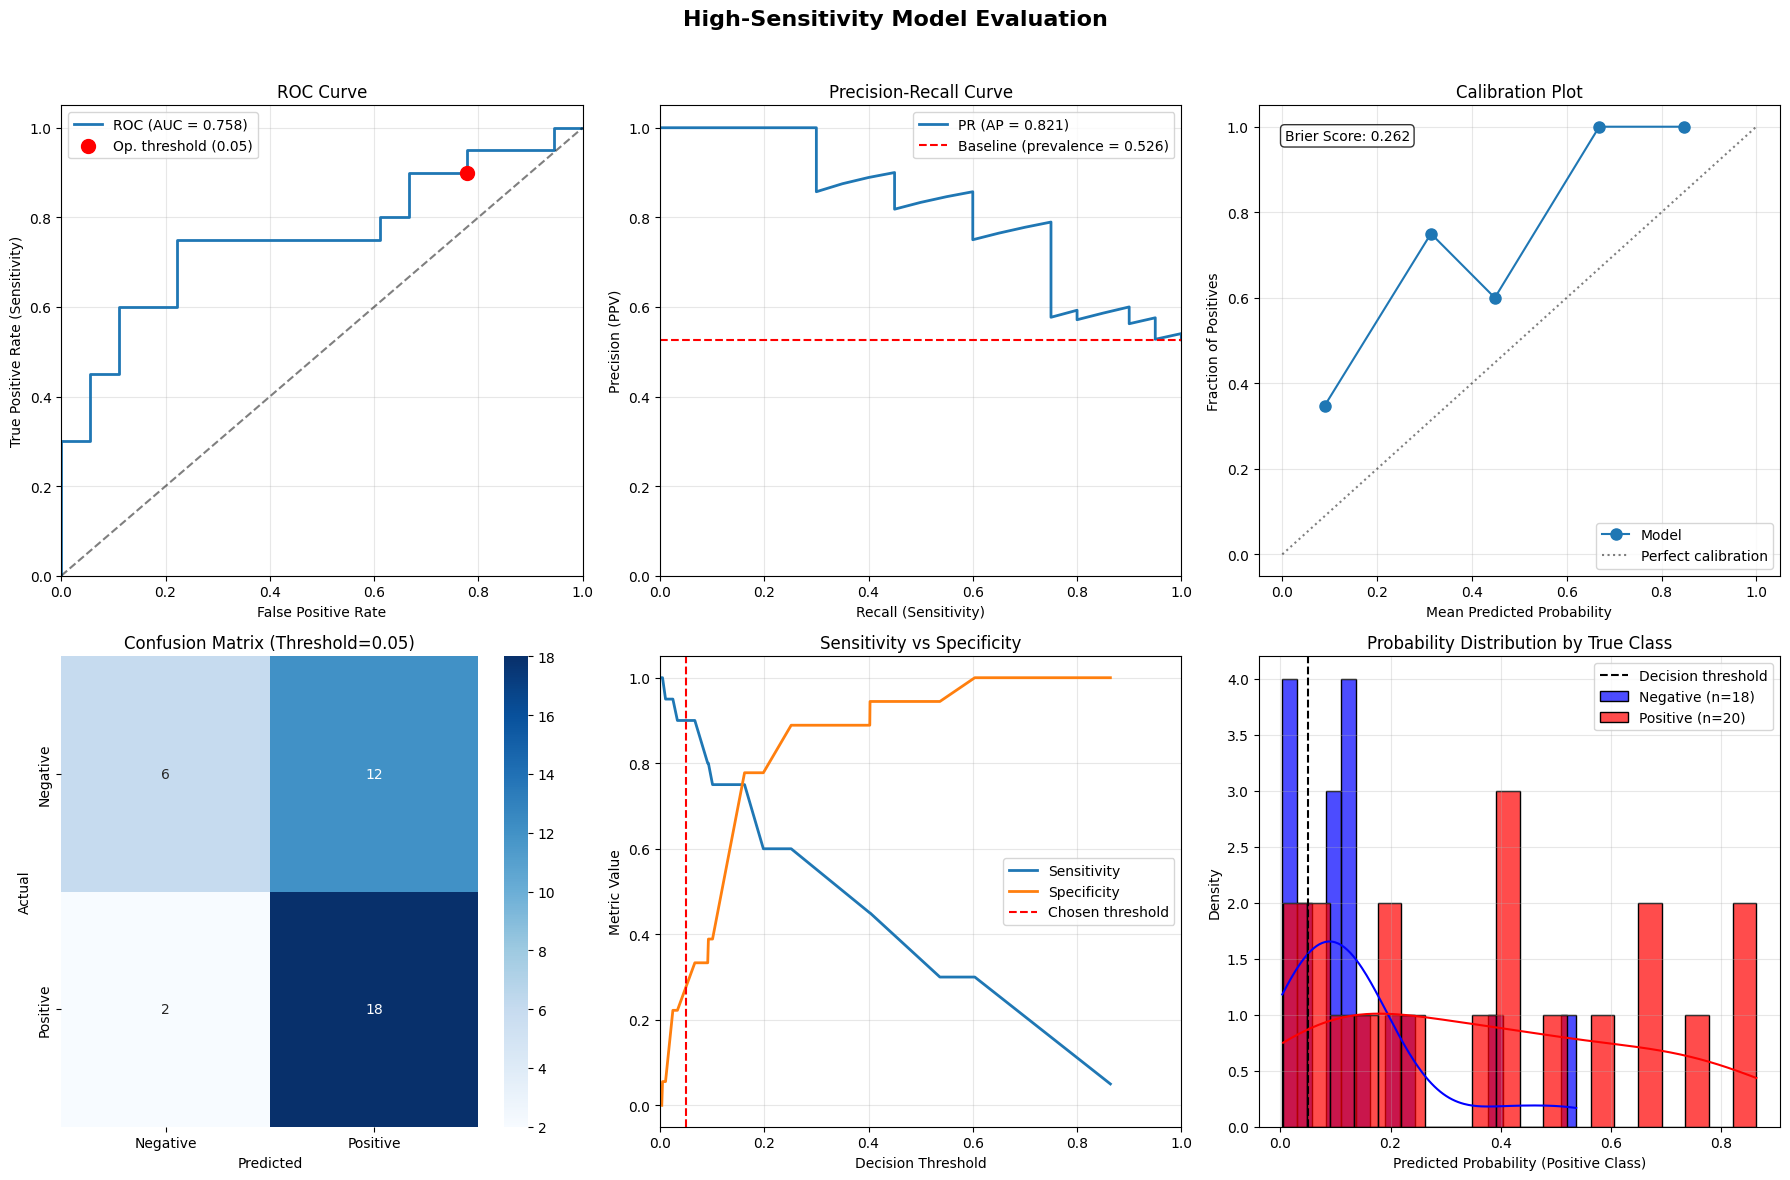


--- False Positives (Sample) ---


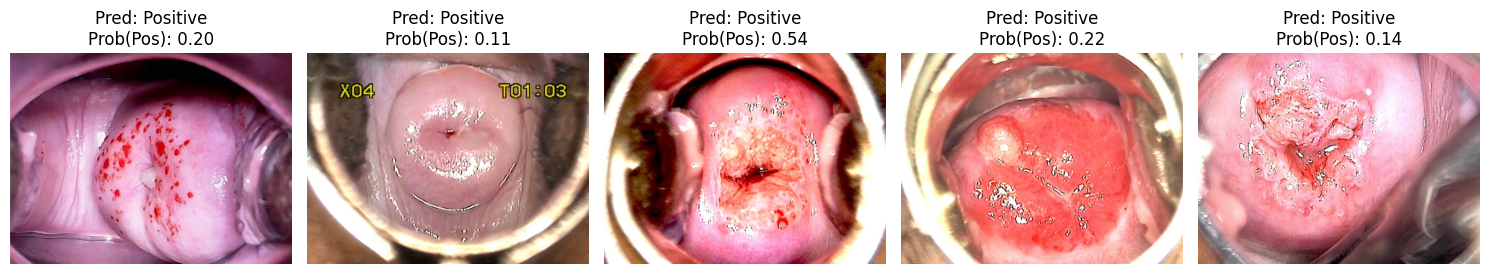


--- False Negatives (Sample) ---


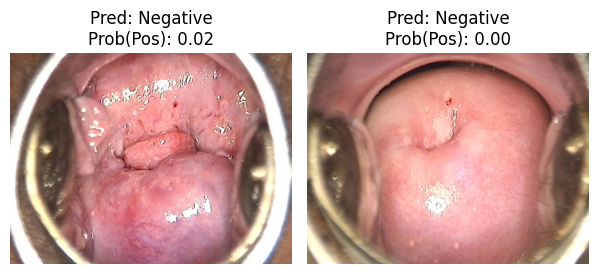


--- Inter-Rater (Model vs. Model) Agreement ---
Loading model: artifacts\ssl_model_best_001_57.9.pth
Model loaded successfully
  Training epoch: 1
  Validation accuracy: 57.89%
Loading model: artifacts\high_sensitivity_model.pth
Model loaded successfully
  Training epoch: 3
  Sensitivity: 0.900
  False Negatives: 2

Cohen's Kappa between SSL model and High-Sensitivity model: 0.189
Interpretation: Fair to slight agreement. The fine-tuning significantly changed the model's behavior.

CLINICAL DEPLOYMENT ASSESSMENT (High-Sensitivity Model)
Model Performance at Optimized Threshold (0.050):
  • AUC: 0.763 (95% CI: [0.596, 0.902])
  • Sensitivity: 0.899 (95% CI: [0.765, 1.000])
  • Specificity: 0.333 (95% CI: [0.117, 0.562])
  • NPV: 0.756 (95% CI: [0.400, 1.000])

Clinical Interpretation:
  ⚠ Sensitivity is below the 95% target, indicating a risk of false negatives.
  ⚠ NPV is below target, suggesting caution is needed for negative predictions.

EVALUATION COMPLETED SUCCESSFULLY
📁 Reports 

In [11]:
# ============================================================
# Execute Evaluation
# ============================================================
if __name__ == "__main__":
    results = main()